<a href="https://colab.research.google.com/github/BSniegowski/ML-uni_course/blob/main/lab/09autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import torch

from torch import nn
from torch.utils.data import Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

import matplotlib.pyplot as plt

import numpy as np

from sklearn.decomposition import PCA

def plot_dataset(train_data, model):
    view_data = train_data.data[:5].view(-1, 28*28) / 255.
    _, decoded_data = model.forward(train_data.data[:5].view(-1, 784).float().cuda() / 255.)
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    plt.suptitle("Reconstruction")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())

        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap='gray')
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())

    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[i].set_xticks(())
            axes[i].set_yticks(())

    plt.show()

def plot_pca(data, model):
    labels = data.classes
    plt.suptitle("Reduction of latent space")
    _ = plt.figure(figsize=(10, 6))
    pca = PCA(2)

    z = model.encode(train_data.data.view(-1, 784).float().cuda())
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())

    for class_idx in range(10):
        indices = (data.targets == class_idx)
        plt.scatter(
            reduced_z[indices, 0], reduced_z[indices, 1],
            s=2., label=labels[class_idx])

    plt.legend()
    plt.show()


torch.manual_seed(1337)
batch_size = 128
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(root='.',
                   train=True,
                   transform=transforms,
                   download=True) # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [2]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim):

        super(AutoEncoder, self).__init__()

        self.latent_dim = latent_dim

        D = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, D),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(D, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 784),
            torch.nn.Sigmoid()
        )

    def decode(self, encoded):
        return self.decoder(encoded)

    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        # encode and decode
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

In [ ]:
# Hyper Parameters
epochs = 25
LR = 5e-3         # learning rate

# prepare original data for plotting

autoencoder = AutoEncoder(latent_dim=10).cuda()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(train_loader):
        x = x.cuda()
        encoded, decoded = autoencoder(x)
        loss_val = rec_loss_fn(decoded, x) # calculate loss
        optimizer.zero_grad()        # clear gradients for this training step
        loss_val.backward()          # backpropagation, compute gradients
        optimizer.step()             # apply gradients

        epoch_losses.append(loss_val.item())

    print(f'Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}')

    if epoch % 10 == 0:
        plot_dataset(train_data, autoencoder)
        plot_pca(train_data, autoencoder)

In [4]:
labeled_data = Subset(train_data, range(100))
labeled_loader = torch.utils.data.DataLoader(dataset=labeled_data, batch_size=32, shuffle=True)

test_data = MNIST(root='.', 
                   train=False, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=True)

In [5]:
class BaselineModel(nn.Module):
  def __init__(self):
    super(BaselineModel, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32, 10)
    )
    
  def forward(self, x):
    x = self.net(x)
    return x

In [ ]:
#@title show results
def show_results(logs):
  f, ax = plt.subplots(1, 2, figsize=(16, 5))
  ax[0].plot(logs['train_accuracy'], color='C%s' % i, linestyle='--', label='train')
  ax[0].plot(logs['test_accuracy'], color='C%s' % i, label='test')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(logs['train_loss'], color='C%s' % i, linestyle='--', label='train')
  ax[1].plot(logs['test_loss'], color='C%s' % i, label='test')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

In [6]:
#@title training loop
def train(n_epochs, model, logs):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  # Hiperparameters
  learning_rate = 0.05
  momentum = 0.1

  loss_fn = torch.nn.functional.cross_entropy
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  correct, numel = 0, 0

  # Training loop
  for i in range(n_epochs):
    model.train()
    for x, y in labeled_loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      output = model(x)
      y_pred = torch.argmax(output, dim=1)
      correct += torch.sum(y_pred == y).item()
      numel += train_loader.batch_size
      loss = loss_fn(output, y)
      loss.backward()
      optimizer.step()

    logs['train_loss'].append(loss.item())
    logs['train_accuracy'].append(correct / numel)
    correct, numel = 0, 0

    model.eval()
    with torch.no_grad():
      for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        output = model(x_test)
        y_pred = torch.argmax(output, dim=1)
        correct += torch.sum(y_pred == y_test).item()
        numel += test_loader.batch_size
      loss = loss_fn(output, y_test)

    logs['test_loss'].append(loss.item())
    logs['test_accuracy'].append(correct / numel)
    print('test acc', logs['test_accuracy'][-1])
    correct, numel = 0, 0

  # print('max test acc: ', max(logs['test_accuracy']))

In [8]:
model = BaselineModel()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}

train(n_epochs=20, model=model, logs=logs)

test acc 0.1013
test acc 0.1203
test acc 0.1523
test acc 0.1135
test acc 0.1135
test acc 0.1135
test acc 0.1135
test acc 0.1135
test acc 0.1135
test acc 0.1135
test acc 0.1154
test acc 0.1269
test acc 0.1281
test acc 0.1409
test acc 0.1396
test acc 0.1439
test acc 0.1684
test acc 0.1988
test acc 0.1812
test acc 0.222


In [9]:
class ModelWithEncoder(nn.Module):
  def __init__(self, latent_dim):
    super(ModelWithEncoder, self).__init__()
    D = latent_dim
    self.encoder = autoencoder.encoder
    self.net = nn.Sequential(
        nn.Linear(D, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32, 10)
    )
    
  def forward(self, x):
    x = self.encoder(x)
    x = self.net(x)
    return x

In [10]:
model2 = ModelWithEncoder(latent_dim=10)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model2.to(device)


logs2 = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}

train(n_epochs=20, model=model2, logs=logs2)

test acc 0.1655
test acc 0.2129
test acc 0.236
test acc 0.2425
test acc 0.3066
test acc 0.3384
test acc 0.4001
test acc 0.3063
test acc 0.27
test acc 0.3401
test acc 0.3746
test acc 0.3996
test acc 0.2432
test acc 0.3459
test acc 0.4926
test acc 0.2872
test acc 0.5014
test acc 0.2672
test acc 0.4569
test acc 0.5678


In [ ]:
from torchvision.datasets import FashionMNIST


# FashionMNIST dataset
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root='.', 
                   train=True, 
                   transform=transforms,    
                   download=True)

batch_size = 256
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 

_, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap='gray')
plt.suptitle("Fashion MNIST")
plt.show()

In [27]:
class WAEMMD(nn.Module):
    
    def __init__(self, latent_dim):
        
        super(WAEMMD, self).__init__()
        
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784)
        )
        
    def decode(self, encoded):
        return self.decoder(encoded)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    def mmd_loss(self, y, sigma):
      numel = y.size()[0]
      z = torch.randn(y.size()).cuda()
      y_z = torch.cat([y.detach(), z.detach()], dim=0)
      dists = torch.cdist(y_z, y_z, p=2.0)
      dists **= 2
      dists = sigma/(sigma+dists)
      k_y = dists[:numel, :numel]
      k_z = dists[numel:, numel:]
      k_yz = dists[:numel, numel:]
      return torch.mean(k_y) + torch.mean(k_z) - 2*torch.mean(k_yz)

Epoch: 0 | train loss: 0.1389256715774536


<Figure size 432x288 with 0 Axes>

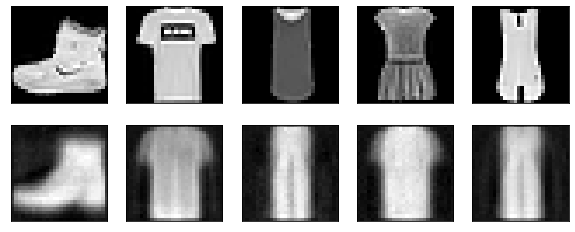

<Figure size 432x288 with 0 Axes>

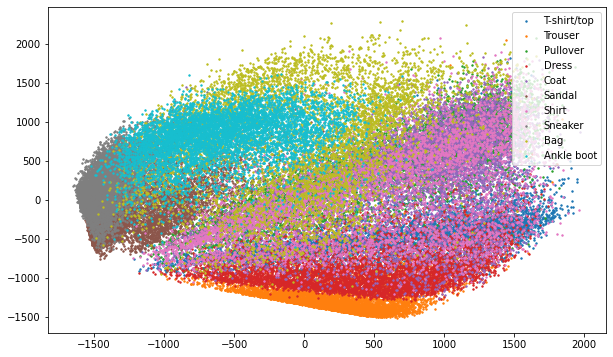

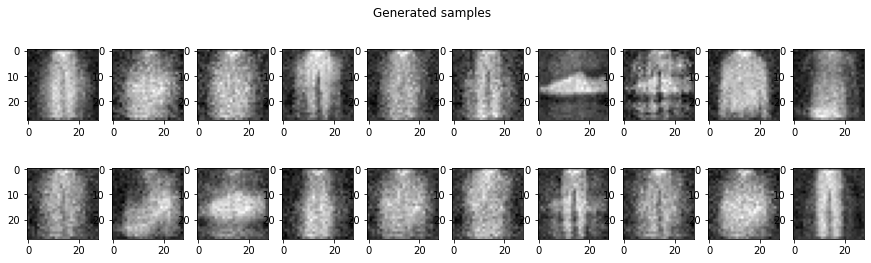

Epoch: 1 | train loss: 0.1483948975801468
Epoch: 2 | train loss: 0.12697087228298187
Epoch: 3 | train loss: 0.1136125922203064
Epoch: 4 | train loss: 0.1311192512512207
Epoch: 5 | train loss: 0.10783886909484863
Epoch: 6 | train loss: 0.1101858988404274
Epoch: 7 | train loss: 0.11462089419364929
Epoch: 8 | train loss: 0.11139509826898575
Epoch: 9 | train loss: 0.09948355704545975
Epoch: 10 | train loss: 0.1020369902253151


<Figure size 432x288 with 0 Axes>

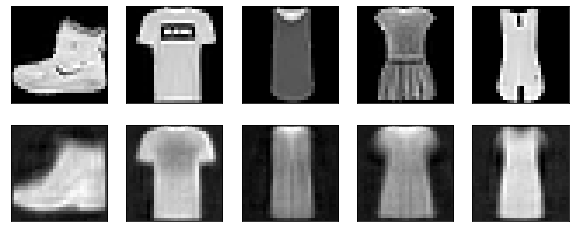

<Figure size 432x288 with 0 Axes>

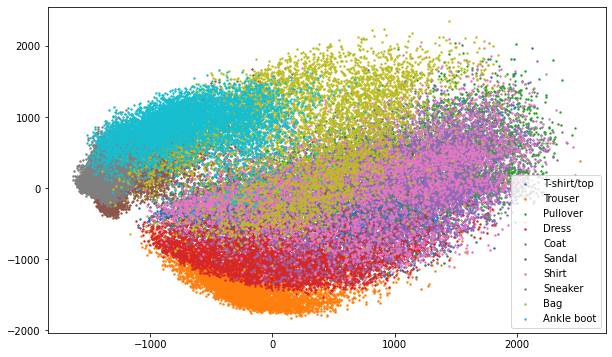

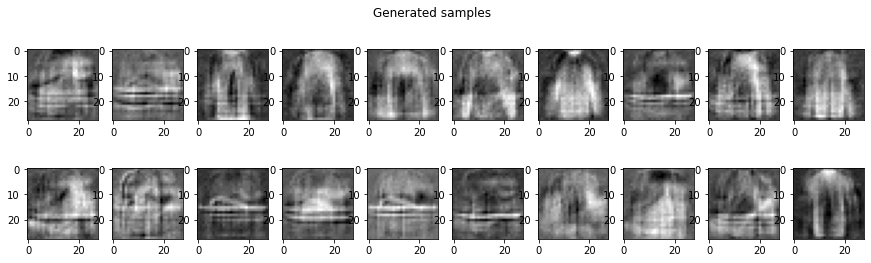

Epoch: 11 | train loss: 0.10434652119874954
Epoch: 12 | train loss: 0.10726471245288849
Epoch: 13 | train loss: 0.09638996422290802
Epoch: 14 | train loss: 0.0941082015633583
Epoch: 15 | train loss: 0.09828460961580276
Epoch: 16 | train loss: 0.10167216509580612
Epoch: 17 | train loss: 0.09103482216596603
Epoch: 18 | train loss: 0.09216707944869995
Epoch: 19 | train loss: 0.09784775227308273
Epoch: 20 | train loss: 0.09494243562221527


<Figure size 432x288 with 0 Axes>

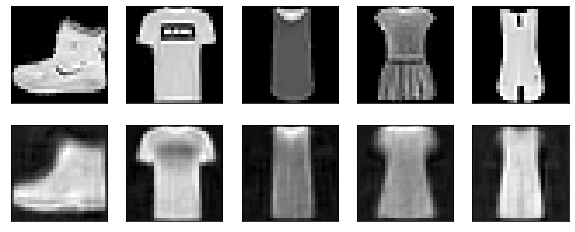

<Figure size 432x288 with 0 Axes>

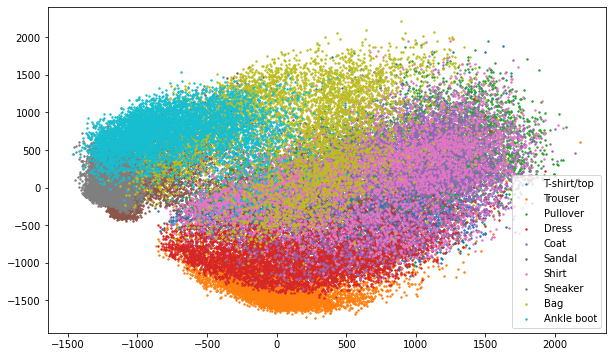

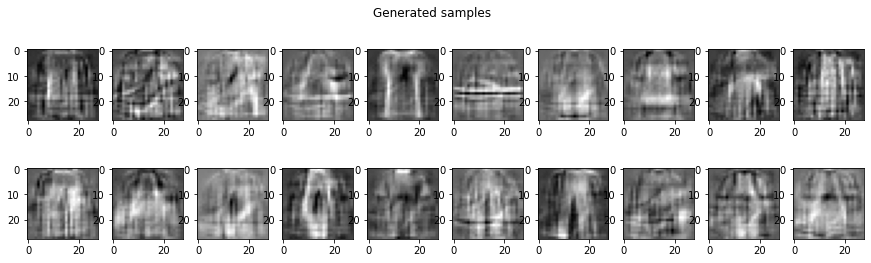

Epoch: 21 | train loss: 0.09649438410997391
Epoch: 22 | train loss: 0.09577413648366928
Epoch: 23 | train loss: 0.09315356612205505
Epoch: 24 | train loss: 0.10125033557415009
Epoch: 25 | train loss: 0.09026696532964706
Epoch: 26 | train loss: 0.09800081700086594
Epoch: 27 | train loss: 0.09526773542165756
Epoch: 28 | train loss: 0.08939291536808014
Epoch: 29 | train loss: 0.09418810158967972
Epoch: 30 | train loss: 0.09464147686958313


<Figure size 432x288 with 0 Axes>

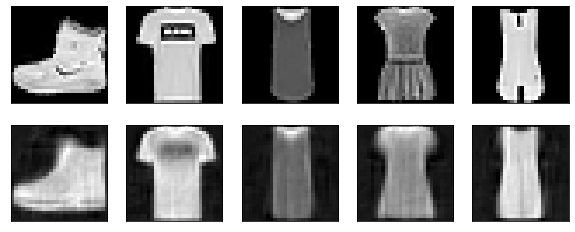

<Figure size 432x288 with 0 Axes>

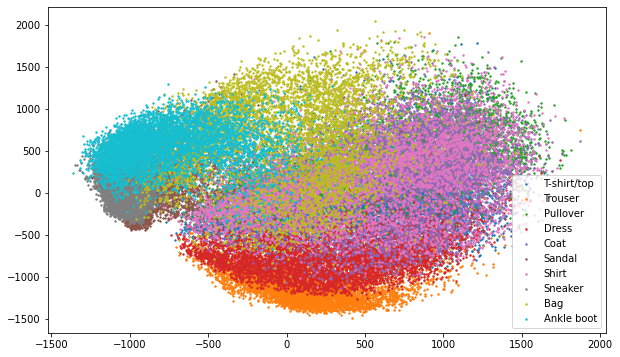

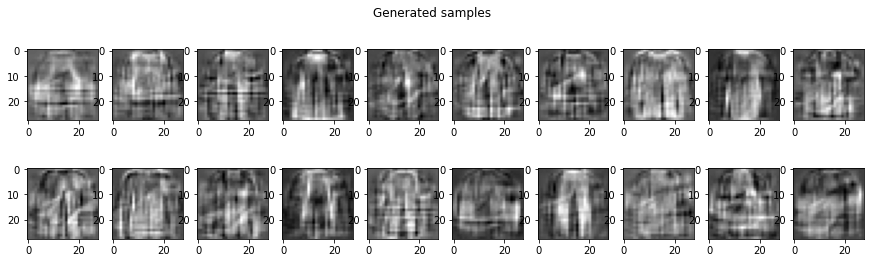

Epoch: 31 | train loss: 0.09406489133834839
Epoch: 32 | train loss: 0.09040959179401398
Epoch: 33 | train loss: 0.08977267146110535
Epoch: 34 | train loss: 0.0912327766418457
Epoch: 35 | train loss: 0.09431580454111099
Epoch: 36 | train loss: 0.09780444204807281
Epoch: 37 | train loss: 0.08743813633918762
Epoch: 38 | train loss: 0.09021922200918198
Epoch: 39 | train loss: 0.09036066383123398
Epoch: 40 | train loss: 0.08620168268680573


<Figure size 432x288 with 0 Axes>

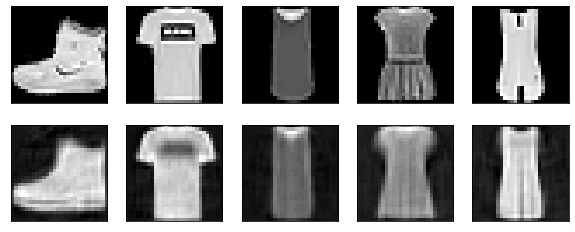

<Figure size 432x288 with 0 Axes>

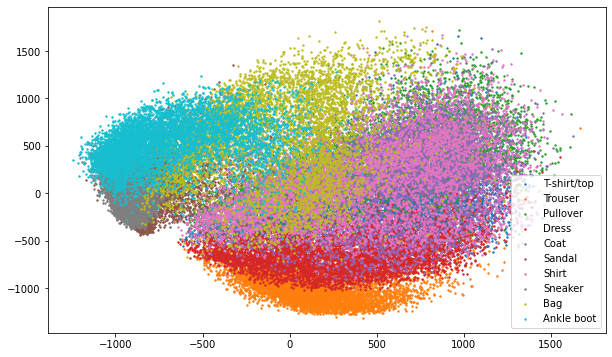

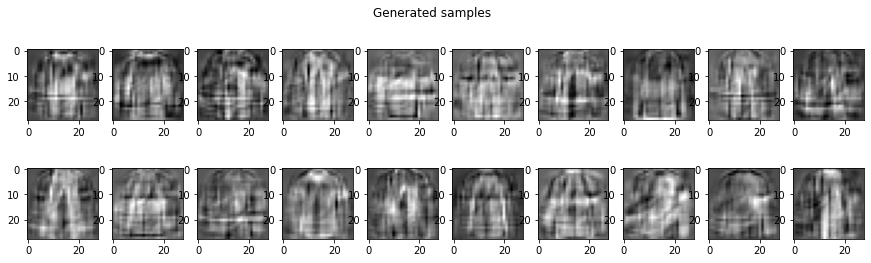

Epoch: 41 | train loss: 0.09595365822315216
Epoch: 42 | train loss: 0.09548871219158173
Epoch: 43 | train loss: 0.09483200311660767
Epoch: 44 | train loss: 0.09011957794427872
Epoch: 45 | train loss: 0.08969025313854218
Epoch: 46 | train loss: 0.09617984294891357
Epoch: 47 | train loss: 0.08478087931871414
Epoch: 48 | train loss: 0.0901673436164856
Epoch: 49 | train loss: 0.09169914573431015
Epoch: 50 | train loss: 0.09264916926622391


<Figure size 432x288 with 0 Axes>

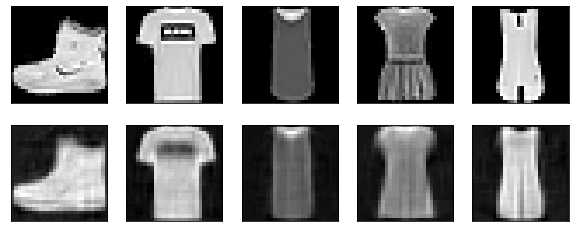

<Figure size 432x288 with 0 Axes>

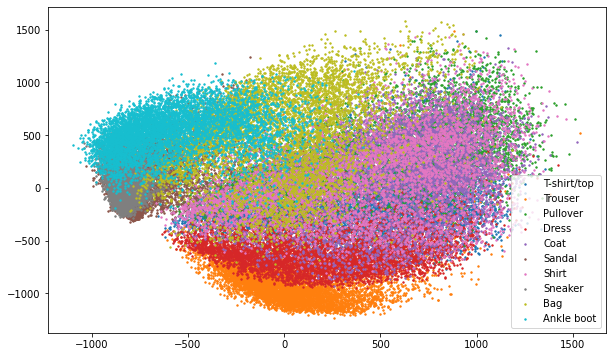

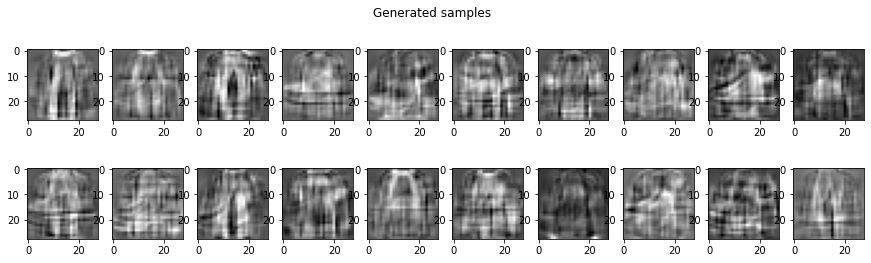

Epoch: 51 | train loss: 0.09028557687997818
Epoch: 52 | train loss: 0.0908508449792862
Epoch: 53 | train loss: 0.08550962805747986
Epoch: 54 | train loss: 0.08863641321659088
Epoch: 55 | train loss: 0.0854409709572792
Epoch: 56 | train loss: 0.08938755095005035
Epoch: 57 | train loss: 0.09094145894050598
Epoch: 58 | train loss: 0.0894625335931778
Epoch: 59 | train loss: 0.0891229435801506
Epoch: 60 | train loss: 0.08830289542675018


<Figure size 432x288 with 0 Axes>

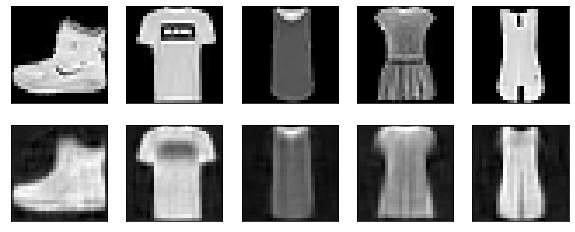

<Figure size 432x288 with 0 Axes>

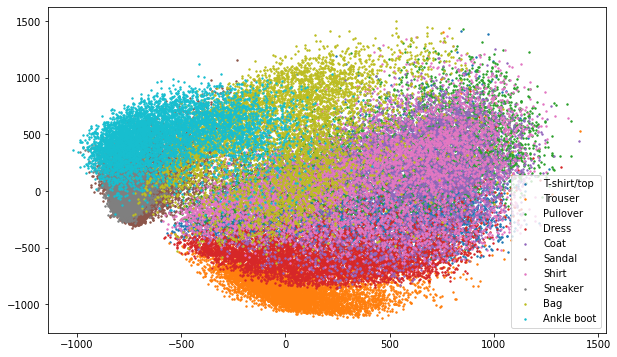

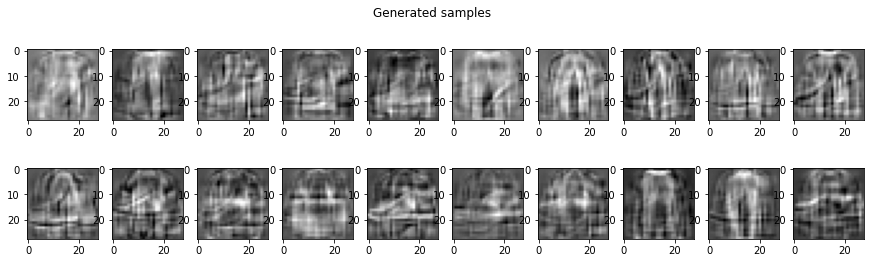

Epoch: 61 | train loss: 0.08954757452011108
Epoch: 62 | train loss: 0.08893952518701553
Epoch: 63 | train loss: 0.09260787814855576
Epoch: 64 | train loss: 0.08953689783811569
Epoch: 65 | train loss: 0.08625924587249756
Epoch: 66 | train loss: 0.09030406177043915
Epoch: 67 | train loss: 0.09012644737958908
Epoch: 68 | train loss: 0.08892907947301865
Epoch: 69 | train loss: 0.08706510066986084
Epoch: 70 | train loss: 0.0910564437508583


<Figure size 432x288 with 0 Axes>

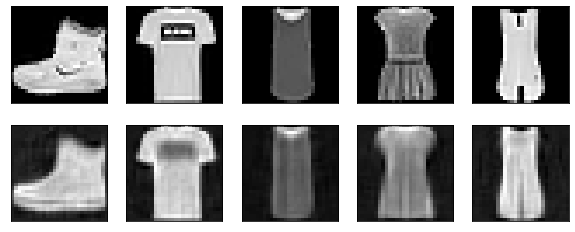

<Figure size 432x288 with 0 Axes>

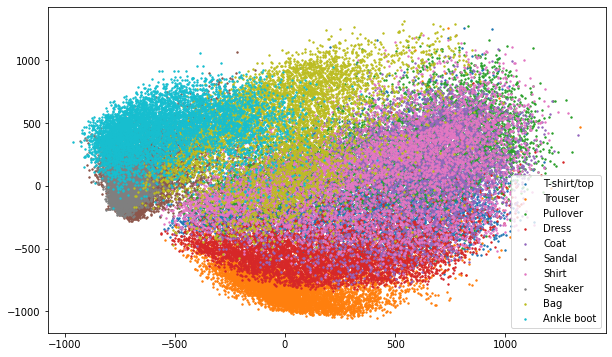

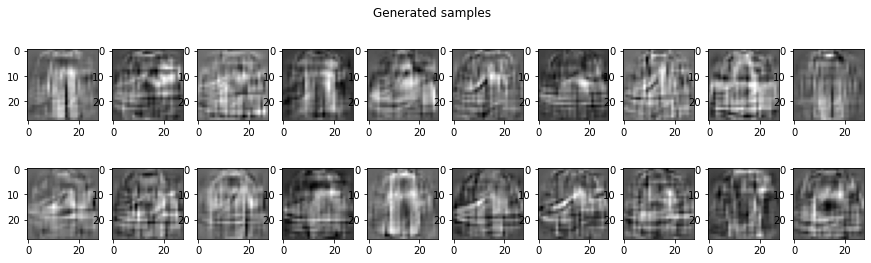

Epoch: 71 | train loss: 0.08987393975257874
Epoch: 72 | train loss: 0.08902406692504883
Epoch: 73 | train loss: 0.0897926464676857
Epoch: 74 | train loss: 0.09218928962945938
Epoch: 75 | train loss: 0.08806294947862625
Epoch: 76 | train loss: 0.08988064527511597
Epoch: 77 | train loss: 0.08994169533252716
Epoch: 78 | train loss: 0.08902199566364288
Epoch: 79 | train loss: 0.0865720808506012
Epoch: 80 | train loss: 0.08939261734485626


<Figure size 432x288 with 0 Axes>

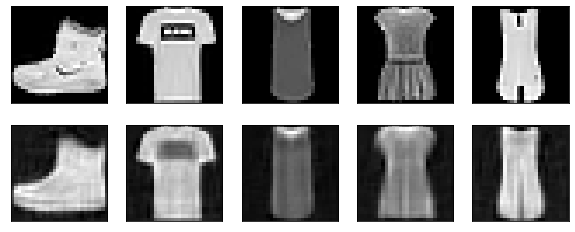

<Figure size 432x288 with 0 Axes>

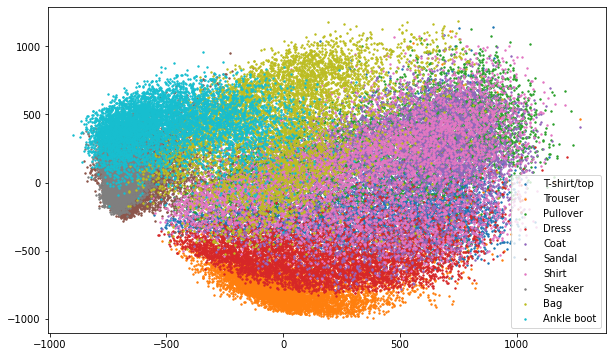

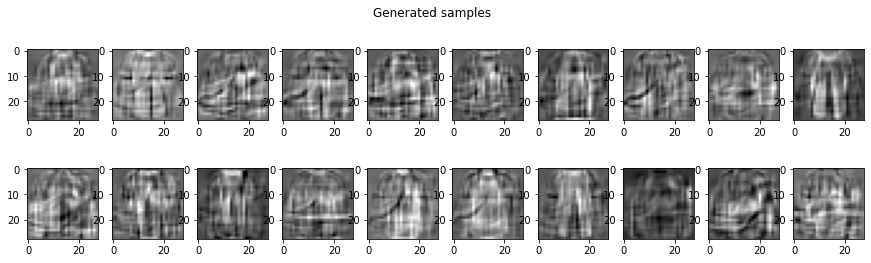

Epoch: 81 | train loss: 0.09323182702064514
Epoch: 82 | train loss: 0.09176551550626755
Epoch: 83 | train loss: 0.08936934918165207
Epoch: 84 | train loss: 0.08821407705545425
Epoch: 85 | train loss: 0.09151183813810349
Epoch: 86 | train loss: 0.08654800057411194
Epoch: 87 | train loss: 0.08975133299827576
Epoch: 88 | train loss: 0.08520279824733734
Epoch: 89 | train loss: 0.08937391638755798
Epoch: 90 | train loss: 0.08993504196405411


<Figure size 432x288 with 0 Axes>

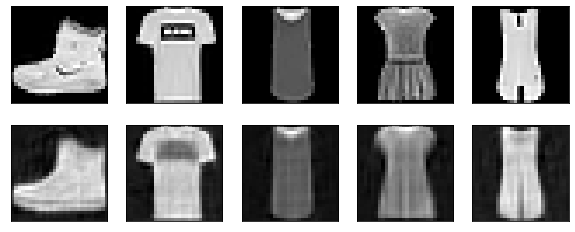

<Figure size 432x288 with 0 Axes>

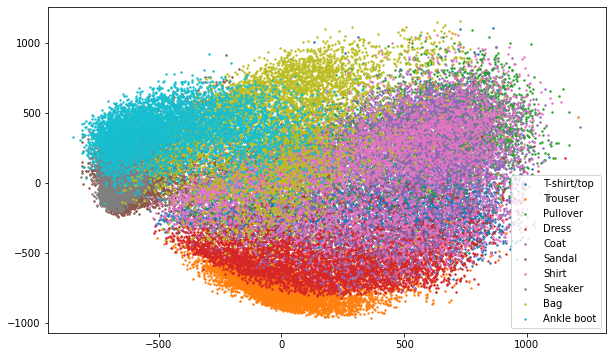

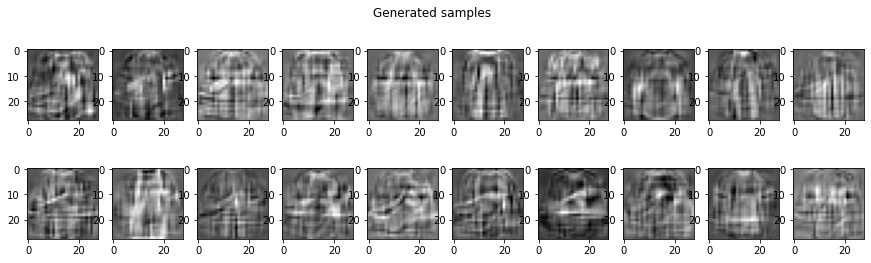

Epoch: 91 | train loss: 0.08780134469270706
Epoch: 92 | train loss: 0.09251262247562408
Epoch: 93 | train loss: 0.09155666828155518
Epoch: 94 | train loss: 0.0913749635219574
Epoch: 95 | train loss: 0.08907018601894379
Epoch: 96 | train loss: 0.0852862223982811
Epoch: 97 | train loss: 0.08798288553953171
Epoch: 98 | train loss: 0.08685982972383499
Epoch: 99 | train loss: 0.08868183940649033


In [34]:
def plot_samples(model):
    # Important part - sampling from normal distribution and passing the results through the decoder.
    sampled_z = torch.randn(20, model.latent_dim).cuda()
    generated = model.decode(sampled_z)

    # Plotting the results
    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()

D = 100
sigma = 2*D
C = 0.5
LR = 0.001
epochs = 100

wae = WAEMMD(D).cuda()

optimizer = torch.optim.Adam(wae.parameters(), LR)

def loss_fn(x):
  mse_fn = nn.MSELoss()
  y = wae.encode(x)
  mse = mse_fn(x, wae.decode(y))
  dk2 = wae.mmd_loss(y, sigma)
  return mse + C * dk2

for epoch in range(epochs):
  for x, y in train_loader:
    x = x.cuda()
    optimizer.zero_grad()
    loss_val = loss_fn(x)
    loss_val.backward()
    optimizer.step()

  print(f'Epoch: {epoch} | train loss: {loss_val}')
    
  if epoch % 10 == 0:
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)